In [1]:
import pandas as pd
import gc
import polars as pl
from tqdm.auto import tqdm
from scipy.optimize import curve_fit
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from utils import *
from scipy.optimize import minimize_scalar


set_config(transform_output="pandas")
pl.enable_string_cache()

## cargamos los datos
lazy_wide_df = pl.scan_parquet("../data/wide.parquet")
#print(lazy_wide_df.collect_schema())

lazy_test_df = pl.scan_parquet("../data/ids_test_expanded.parquet")


In [2]:
# ==========================================
# CONFIGURACIÓN DE MODELOS Y PREPROCESSORS
# ==========================================

# Configuración del preprocessor
preprocessor_region = ColumnTransformer(
    transformers=[
        (
            "onehot",
            OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
            ["store_type", "brand_house", "cluster"],
        ),
        (
            "ordinal",
            OrdinalEncoder(categories=[["Primavera", "Verano", "Otoño", "Invierno"]]),
            ["estacion"],
        ),
        (
            "scaler",
            StandardScaler(),
            [
                "residuos_precio",
                "loyalty_count",
                "non_loyalty_count",
                "year",
                "quantity",
                "days_since_start",
                "avg_price_ratio",
                "avg_profit_ratio",
            ],
        ),
    ],
    remainder="passthrough",
)

# Pipeline optimizado
pipeline_region = make_pipeline(
    preprocessor_region,
    HistGradientBoostingRegressor(
        max_iter=200,
        max_depth=6,
        learning_rate=0.05,
        min_samples_leaf=15,
        validation_fraction=0.2,
        early_stopping=True,
        random_state=42,
    ),
)

# ==========================================
# PREPARACIÓN DE DATOS AGRUPADOS
# ==========================================
# Lazy grouped corregido para región

# Lazy grouped corregido para región
lazy_grouped_region = (lazy_wide_df
    .group_by(
        [
            "subgroup", "region", "store_id", "cluster", "store_type",
            "estacion", "day", "days_since_start", "weekday", "month", 
            "year", "brand_house", "quantity","date","store_subgroup_date_id"
        ] 
    )
    .agg(
        [
            pl.col("price").mean().alias("price"),
            pl.col("total_sales").sum().alias("total_sales"),
            pl.col("day_sin").mean().alias("day_sin"),
            pl.col("day_cos").mean().alias("day_cos"),
            pl.col("weekday_sin").mean().alias("weekday_sin"),
            pl.col("weekday_cos").mean().alias("weekday_cos"),
            pl.col("month_sin").mean().alias("month_sin"),
            pl.col("month_cos").mean().alias("month_cos"),
            pl.col("loyalty_count").mean().alias("loyalty_count"),
            pl.col("non_loyalty_count").mean().alias("non_loyalty_count"),
            pl.col("base_price").mean().alias("base_price"),
            pl.col("costos").mean().alias("costos"),
            # pl.col("quantity").mean().alias("quantity"),
        ]
    )
    .with_columns(
        (pl.col("price") / pl.col("base_price")).alias("avg_price_ratio"),
        (pl.col("price") / pl.col("costos")).alias("avg_profit_ratio"),
    )
)
lazy_grouped_region_test = (lazy_wide_df
    .group_by(
        [
            "subgroup", "region", "store_id", "cluster", "store_type",
            "estacion", "day", "days_since_start", "weekday", "month", 
            "year", "brand_house", "date", "store_subgroup_date_id"
        ] 
    )
    .agg(
        [
            pl.col("price").mean().alias("price"),
            pl.col("total_sales").sum().alias("total_sales"),
            pl.col("quantity").sum().alias("quantity"),  # Acá no agrupamos por quantity sino que lo sumamos
            pl.col("day_sin").mean().alias("day_sin"),
            pl.col("day_cos").mean().alias("day_cos"),
            pl.col("weekday_sin").mean().alias("weekday_sin"),
            pl.col("weekday_cos").mean().alias("weekday_cos"),
            pl.col("month_sin").mean().alias("month_sin"),
            pl.col("month_cos").mean().alias("month_cos"),
            pl.col("loyalty_count").mean().alias("loyalty_count"),
            pl.col("non_loyalty_count").mean().alias("non_loyalty_count"),
            pl.col("base_price").mean().alias("base_price"),
            pl.col("costos").mean().alias("costos"),
        ]
    )
)



In [3]:
# ==========================================
# LOOP PRINCIPAL CON POLARS
# ==========================================

def predict_total_sales_for_price_residuals(residuos_precio, X_base_sample,pipeline):
                """Predice total_sales para un precio dado"""
                X_sim = X_base_sample.copy()
                X_sim["residuos_precio"] = residuos_precio #se lo damos nosotros para que lo mueva
                return pipeline.predict(X_sim)

def calculate_total_profit(residuos_precio, X_base_sample, pipeline):
    """
    Calcula la ganancia total para un valor dado de residuos_precio.
    VERSIÓN CORREGIDA: Predice quantity, no usa quantity histórica
    
    Args:
        residuos_precio: Valor de residual de precio a evaluar
        X_base_sample: DataFrame con features base
        pipeline: Pipeline entrenado que predice total_sales
        
    Returns:
        float: Ganancia total calculada
    """
    # Crear datos con el nuevo residual
    X_temp = X_base_sample.copy()
    X_temp['residuos_precio'] = residuos_precio
    
    # Predecir total_sales con el pipeline
    predicted_total_sales = pipeline.predict(X_temp)
    
    # Calcular nuevo precio: precio_sinusoidal + residual
    new_price = X_temp['price'] - X_temp['residuos_precio'] + residuos_precio
    
    # Validar que el precio sea positivo
    new_price = np.maximum(new_price, 0.01)  # Evitar precios <= 0
    
    # Calcular cantidad implícita: total_sales / precio
    predicted_quantity = predicted_total_sales / new_price
    
    # Calcular ganancia: ingresos - costos
    # Ingresos = total_sales_predicho
    # Costos = costo_unitario * cantidad_predicha
    revenue = predicted_total_sales
    costs = X_temp['costos'] * predicted_quantity
    profit = revenue - costs
    
    return profit.sum()

def negative_profit(residuos_precio, X_base_sample,pipeline):
    """Función objetivo (negativa porque minimize_scalar minimiza)"""
    return -calculate_total_profit(residuos_precio, X_base_sample,pipeline)


# Configuración
TRAIN_DATA_MIN_DATE = pd.to_datetime("2023-01-01")
TEST_DATA_MAX_DATE = pd.to_datetime("2023-01-08")
LIMIT_PRODUCTS = None  # None para procesar todos, número para limitar (ej: 3)
LIMIT_REGIONS = None   # None para procesar todas, número para limitar (ej: 2)
USE_REGIONS = False     # True para procesar por región, False para procesar sin filtrar por región

# Variables para resultados
dict_results = {}
dict_opt = {}
# Obtener listas de productos y regiones (eficiente con Polars)
productos = lazy_test_df.select("subgroup").unique().collect().to_pandas()["subgroup"].values
regiones = lazy_test_df.select("region").unique().collect().to_pandas()["region"].values

# Aplicar límites si están configurados
if LIMIT_PRODUCTS:
    productos = productos[:LIMIT_PRODUCTS]
if LIMIT_REGIONS:
    regiones = regiones[:LIMIT_REGIONS]

# Configurar regiones según USE_REGIONS
if USE_REGIONS:
    print("📊 PROCESANDO CON REGIONES SEPARADAS")
    total_combinations = len(productos) * len(regiones)
else:
    print("📊 PROCESANDO SIN FILTRAR POR REGIÓN")
    regiones = [None]  # Solo un elemento None para procesar sin región
    total_combinations = len(productos)

print("📊 CONFIGURACIÓN DE PROCESAMIENTO:")
print(f"   - Productos: {len(productos)}")
print(f"   - Regiones: {len(regiones) if USE_REGIONS else 'Todas juntas'}")
print(f"   - Total combinaciones: {total_combinations}")
print(f"   - Memoria inicial: {check_memory():.1f} MB")
print("=" * 50)

# Contador y procesamiento
count = 0

for prod in tqdm(productos, desc="Productos"):
    print(f"\n🎯 PRODUCTO: {prod}")
    
    # Caso especial: Basketball
    if prod == "Basketball":
        print("   📝 Caso especial: asignando ventas = 0")
        basketball_results = process_basketball_special_case(lazy_test_df, prod)
        dict_results.update(basketball_results)
        count += len(regiones)  # Contamos todas las regiones como procesadas
        continue
    
    # Procesar cada región para este producto (o None si USE_REGIONS=False)
    for region in regiones:
        count += 1
        progress = (count / total_combinations) * 100
        
        if USE_REGIONS:
            print(f"   🌍 Región: {region} ({count}/{total_combinations} - {progress:.1f}%)")
        else:
            print(f"   🌐 Procesando todas las regiones juntas ({count}/{total_combinations} - {progress:.1f}%)")

        try:
            # Usar versión optimizada
            lazy_wide_df_opt = lazy_wide_df.filter(pl.col("date") < pl.lit(TRAIN_DATA_MIN_DATE))
            lazy_grouped_region_opt = lazy_grouped_region.filter(pl.col("date") < pl.lit(TRAIN_DATA_MIN_DATE))
            lazy_test_df_opt = lazy_grouped_region.filter((pl.col("date") > pl.lit(TRAIN_DATA_MIN_DATE)) & (pl.col("date") <= pl.lit(TRAIN_DATA_MIN_DATE)))
            lazy_test_df_opt = lazy_grouped_region_test.filter(
                (pl.col("date") >= pl.lit(TRAIN_DATA_MIN_DATE))
                & (pl.col("date") <= pl.lit(TEST_DATA_MAX_DATE))
            )
            region_results,pipeline,test_df_processed,sinusoidal_params = process_product_region_combination_polars_ganancias(
                prod, region, lazy_grouped_region_opt, lazy_wide_df_opt, lazy_test_df_opt, pipeline_region,
            )

            # Agregar resultados
            dict_results.update(region_results)

            
            # 10. Preparar datos base para simulación (sin precio)
            X_base = test_df_processed.copy()
            
            # 11. Definir rango de residuos y precios para optimización
            # merge dos enfoques: residuos y porcentaje de precios
            current_residuos_mean = test_df_processed["residuos_precio"].mean()
            residuos_std = test_df_processed["residuos_precio"].std()
            
            # 1. Basado en distribución histórica de residuos
            residuos_min = current_residuos_mean - 2 * residuos_std
            residuos_max = current_residuos_mean + 2 * residuos_std

            # 2. Basado en cambios de precio económicamente razonables
            precio_actual_mean = test_df_processed["price"].mean()
            costo_medio = test_df_processed["costos"].mean()
            
            # Rango de precios finales deseado
            precio_min_deseado = max(costo_medio * 1.1, precio_actual_mean * 0.8)  # Costo + 10% o -20%
            precio_max_deseado = precio_actual_mean * 1.3  # +30%
            
            # Convertir a residuos (restar el componente sinusoidal promedio)
            seno_promedio = sinusoidal_func(test_df_processed["days_since_start"].mean(), *sinusoidal_params)
            residuos_min_economico = precio_min_deseado - seno_promedio
            residuos_max_economico = precio_max_deseado - seno_promedio
            
            # Usar el rango más conservador: el que está más cerca de los valores actuales
            residuos_min = max(residuos_min, residuos_min_economico)
            residuos_max = min(residuos_max, residuos_max_economico)

            # 12. Optimizamos precio
            print(" Optimizando precio...")
            result = minimize_scalar(
                negative_profit,
                bounds=(residuos_min, residuos_max),
                method='bounded',
                args=(X_base,  pipeline))
            
            optimal_residuals = result.x
            max_profit = -result.fun
            
            # 13. Calculamos la ganancia actual CONSISTENTE con el método de optimización
            current_profit_calculated = calculate_total_profit(current_residuos_mean, X_base, pipeline)

            # calculamos la ganancia real en ese periodo para tener como referencia
            current_test_df_opt = lazy_test_df_opt.select(pl.col("total_sales"), pl.col("costos"), pl.col("quantity")).collect().to_pandas()
            current_profit_real = (current_test_df_opt["total_sales"] - current_test_df_opt["costos"] * current_test_df_opt["quantity"]).sum()
            current_profit = current_profit_calculated
            
            #optimizamos los precios para maximizar la ganancia en el test
            dict_opt[prod] = {
                "optimal_residuals": optimal_residuals,
                "max_profit": max_profit,
                "current_profit": current_profit
            }

        except Exception as e:
            print(f"   ❌ Error en {prod}-{region}: {e}")
            continue
    
    # Limpieza de memoria agresiva
    if count % 5 == 0:  # Cada 5 iteraciones en lugar de 10
        current_memory = check_memory()
        gc.collect()
        new_memory = check_memory()
        print(f"   🧹 Memoria: {current_memory:.1f} → {new_memory:.1f} MB (liberados: {current_memory-new_memory:.1f} MB)")

print("\n" + "=" * 50)
print(f"✅ PROCESAMIENTO COMPLETADO")
print(f"   - Total predicciones generadas: {len(dict_results):,}")
print(f"   - Combinaciones procesadas: {count}/{total_combinations}")
print("=" * 50)


📊 PROCESANDO SIN FILTRAR POR REGIÓN
📊 CONFIGURACIÓN DE PROCESAMIENTO:
   - Productos: 74
   - Regiones: Todas juntas
   - Total combinaciones: 74
   - Memoria inicial: 273.5 MB


Productos:   0%|          | 0/74 [00:00<?, ?it/s]


🎯 PRODUCTO: Nuts
   🌐 Procesando todas las regiones juntas (1/74 - 1.4%)
   Procesando: Nuts - None
   📊 Filas antes filtrado: 142,363
   🗑️ Outliers removidos: 311 (0.2%)
   R² ajuste sinusoidal: 0.825
score: 0.25243872098867093
   ✅ Generadas 845 predicciones
 Optimizando precio...

🎯 PRODUCTO: Accessories
   🌐 Procesando todas las regiones juntas (2/74 - 2.7%)
   Procesando: Accessories - None
   📊 Filas antes filtrado: 66,762
   🗑️ Outliers removidos: 451 (0.7%)
   R² ajuste sinusoidal: 0.474
score: -0.09628313908209862
   ✅ Generadas 442 predicciones
 Optimizando precio...

🎯 PRODUCTO: Dining
   🌐 Procesando todas las regiones juntas (3/74 - 4.1%)
   Procesando: Dining - None
   📊 Filas antes filtrado: 73,005
   🗑️ Outliers removidos: 679 (0.9%)
   R² ajuste sinusoidal: 0.492
score: 0.16768854770383268
   ✅ Generadas 432 predicciones
 Optimizando precio...

🎯 PRODUCTO: Camping
   🌐 Procesando todas las regiones juntas (4/74 - 5.4%)
   Procesando: Camping - None
   📊 Filas antes f

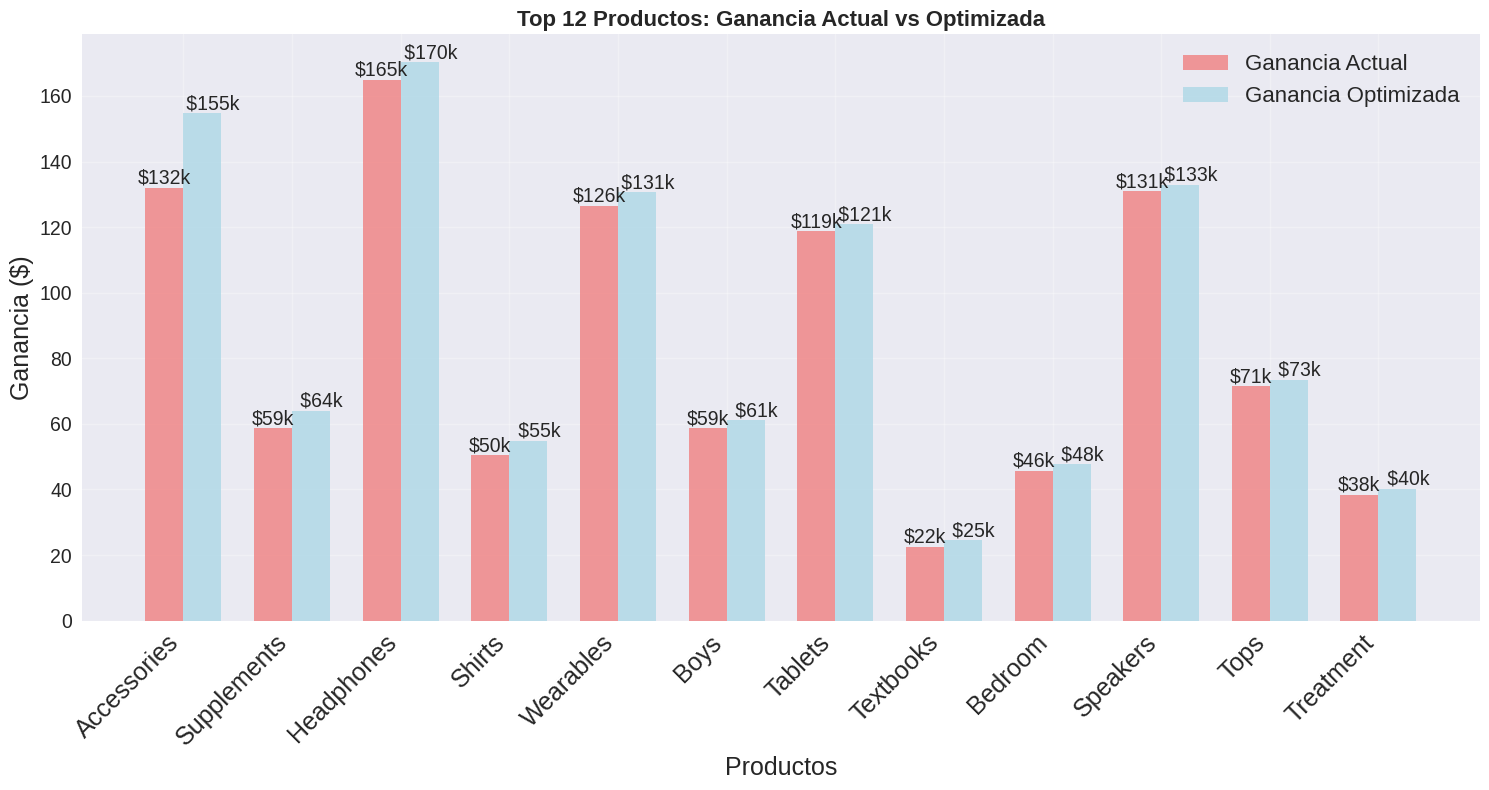

In [4]:
# Plot de Top Productos por Mejora en Ganancia
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def plot_top_products_simple(dict_opt, top_n=12):
    """
    Crea un gráfico simple de los productos con mayor mejora en ganancia
    """
    
    # Convertir diccionario a DataFrame
    results_df = pd.DataFrame.from_dict(dict_opt, orient='index').reset_index()
    results_df.columns = ['producto', 'optimal_residuals', 'max_profit', 'current_profit']
    
    # Calcular métricas adicionales
    results_df['profit_improvement'] = results_df['max_profit'] - results_df['current_profit']
    results_df['profit_improvement_pct'] = (results_df['profit_improvement'] / 
                                          results_df['current_profit'].abs()) * 100
    
    # Filtrar valores válidos
    results_df = results_df[
        (results_df['profit_improvement_pct'] >= -100) & 
        (results_df['profit_improvement_pct'] <= 1000) &
        (results_df['current_profit'] != 0)
    ].copy()
    
    plt.figure(figsize=(15, 8))

    top_products = results_df.nlargest(top_n, 'profit_improvement')
    
    x = np.arange(len(top_products))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, top_products['current_profit']/1000, width, 
                   label='Ganancia Actual', alpha=0.8, color='lightcoral')
    bars2 = plt.bar(x + width/2, top_products['max_profit']/1000, width,
                   label='Ganancia Optimizada', alpha=0.8, color='lightblue')
    
    plt.title(f'Top {top_n} Productos: Ganancia Actual vs Optimizada', fontsize=16, fontweight='bold')
    plt.xlabel('Productos', fontsize=18)
    plt.ylabel('Ganancia ($)', fontsize=18)
    plt.xticks(x, top_products['producto'], rotation=45, ha='right', fontsize=18)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=16)
    plt.grid(True, alpha=0.3)
    
    # Agregar precios totales en las barras
    for bar in bars1:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:.0f}k', ha='center', va='bottom', fontsize=14)
    
    for bar in bars2:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'      ${height:.0f}k  ', ha='center', va='bottom', fontsize=14)
    
    plt.tight_layout()
    plt.show()


results_data = plot_top_products_simple(dict_opt, top_n=12)
